# Project: Exploratory Data Analysis (EDA) on Food Service Data

**Setup - Imports and styling**

In [40]:
# Getting the tools (libraries & modules) ready for the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import drive

# Enabling the plots to look clean and readable
plt.style.use('seaborn-v0_8-whitegrid') # A clean and widely used style
sns.set_palette("viridis") # A colorblind-friendly and visually appealing palette
plt.rcParams['figure.dpi'] = 100 # Higher DPI for clearer plots
plt.rcParams['figure.figsize'] = [10, 6] # Default figure size (width, height in inches)
pd.options.display.float_format = '{:.2f}'.format # Format floats to 2 decimal places in pandas outputs

**Mounting Google drive & loading the data**

In [41]:
# Connecting to Google drive to grab the dataset
print("Connecting to Google Drive...")
try:
    drive.mount('/content/drive')
    file_path = '/content/drive/MyDrive/Food data.csv'
    print(f"Drive mounted! Looking for data at: {file_path}")
except Exception as e:
    print(f"Error mounting Drive: {e}")
    raise

# Loading the dataset with robust missing value handling
try:
    df = pd.read_csv(file_path, na_values=['', 'nan', 'NA', 'null'], keep_default_na=True)
    print(f"Data loaded! Shape: {df.shape}")
except FileNotFoundError:
    print(f"File not found: {file_path}")
    raise
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted! Looking for data at: /content/drive/MyDrive/Food data.csv
Data loaded! Shape: (1822, 11)


**Initial data Inspection**

In [42]:
# To have an initial look at data (Sanity Check)
print("--- Initial Data Inspection ---")
if not df.empty:
    print(f"\nShape of the dataset (rows, columns): {df.shape}")

    print("\n--- First 5 Rows ---")
    print(df.head())

    print("\n--- Data Types and Missing Values (Initial) ---")
    df.info() # Provides dtypes and non-null counts, good for spotting initial type issues

    print("\n--- Summary of Missing Values (Initial) ---")
    missing_values_initial = df.isnull().sum()
    missing_percentage_initial = (missing_values_initial / len(df)) * 100
    missing_report_initial = pd.DataFrame({
        'Missing Count': missing_values_initial[missing_values_initial > 0], # Only show columns with missing values
        'Missing Percentage (%)': missing_percentage_initial[missing_percentage_initial > 0]
    })
    if not missing_report_initial.empty:
        print(missing_report_initial.sort_values(by='Missing Count', ascending=False))
    else:
        print("No missing values found initially.")

    print("\n--- Basic Descriptive Statistics for Numeric Columns (Initial) ---")
    print(df.describe(include=np.number))

    print("\n--- Unique Value Counts for Potential Categorical (Object) Columns (Initial) ---")
    for col in df.select_dtypes(include='object').columns:
        print(f"\nUnique values in '{col}':")
        print(df[col].value_counts(dropna=False).head(10)) # Show top 10 unique values and NaNs
else:
    print("DataFrame 'df' is empty. Data loading in Cell 2 might have failed.")

--- Initial Data Inspection ---

Shape of the dataset (rows, columns): (1822, 11)

--- First 5 Rows ---
   ID        date  meals_served kitchen_staff  temperature_C  \
0   0  12/19/2022        196.00            13          27.89   
1   1  11/21/2023        244.00            15          10.32   
2   2    2/1/2022        148.00            16          27.71   
3   3   3/19/2023        157.00            19          19.17   
4   4   7/18/2022        297.00            10          26.38   

   humidity_percent  day_of_week special_event  past_waste_kg  \
0             45.36            0             0           7.74   
1             64.43            1             0          42.31   
2             69.05            1             0          41.18   
3             46.29            6             0          41.54   
4             79.74            0             0          26.53   

  staff_experience waste_category  
0     intermediate          dairy  
1              NaN           MeAt  
2         Be

**Data cleaning & preprocessing**

In [43]:
# --- Data Cleaning and Preprocessing ---
print("\n--- Starting Data Cleaning and Preprocessing ---")
if not df.empty:
    # 1. Standardize column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"Standardized column names: {df.columns.tolist()}")

    # 2. Correct Data Types and Handle Inconsistencies
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        rows_before_date_dropna = len(df)
        df.dropna(subset=['date'], inplace=True)
        if len(df) < rows_before_date_dropna:
            print(f"Dropped {rows_before_date_dropna - len(df)} rows due to invalid date formats.")
        print("'date' column converted to datetime format.")

    if 'special_event' in df.columns:
        event_map_pdf = {'Yes': 1, 'yes': 1, 'One': 1, 'one': 1, 'True': 1, 'true': 1, '1': 1, '1.0': 1,
                         'No': 0, 'no': 0, 'Zero': 0, 'zero': 0, 'False': 0, 'false': 0, '0': 0, '0.0': 0}
        # Explicitly handle potential downcasting if needed after replace, or let pd.to_numeric manage it
        df['special_event'] = df['special_event'].astype(str).str.strip().str.lower().replace(event_map_pdf)
        df['special_event'] = pd.to_numeric(df['special_event'], errors='coerce')
        df['special_event'] = df['special_event'].fillna(0) # Reassignment instead of inplace
        df['special_event'] = df['special_event'].astype(int)
        print(f"'special_event' column cleaned and converted to int. Unique values: {df['special_event'].unique()}")

    if 'kitchen_staff' in df.columns:
        num_word_map_pdf = {
            'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
            'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
            'eleven': 11, 'twelve': 12
        }
        df['kitchen_staff'] = df['kitchen_staff'].astype(str).str.strip().str.lower().replace(num_word_map_pdf)
        df['kitchen_staff'] = pd.to_numeric(df['kitchen_staff'], errors='coerce')
        print(f"'kitchen_staff' column cleaned and coerced to numeric. NaNs before imputation: {df['kitchen_staff'].isnull().sum()}")

    numeric_cols_coerce = ['meals_served', 'temperature_c', 'humidity_percent', 'past_waste_kg']
    for col in numeric_cols_coerce:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"'{col}' column coerced to numeric. NaNs before imputation: {df[col].isnull().sum()}")

    if 'staff_experience' in df.columns:
        df['staff_experience'] = df['staff_experience'].astype(str).str.strip().replace(['nan', 'NaN', 'None', ''], pd.NA, regex=False)
        df['staff_experience'] = df['staff_experience'].str.title()
        experience_replacements_pdf = {'Pro': 'Expert'}
        df['staff_experience'] = df['staff_experience'].replace(experience_replacements_pdf) # Reassignment
        print(f"'staff_experience' cleaned. Unique values: {df['staff_experience'].dropna().unique().tolist() if df['staff_experience'].notna().any() else 'All NaN or Empty'}")

    if 'waste_category' in df.columns:
        df['waste_category'] = df['waste_category'].astype(str).str.strip().replace(['nan', 'NaN', 'None', ''], pd.NA, regex=False)
        df['waste_category'] = df['waste_category'].str.title()
        waste_category_replacements_pdf = {'Barley': 'Grains', 'Wheat': 'Grains'}
        df['waste_category'] = df['waste_category'].replace(waste_category_replacements_pdf) # Reassignment
        print(f"'waste_category' cleaned. Unique values: {df['waste_category'].dropna().unique().tolist() if df['waste_category'].notna().any() else 'All NaN or Empty'}")

    if 'day_of_week' in df.columns:
        df['day_of_week'] = pd.to_numeric(df['day_of_week'], errors='coerce')
        df.loc[~df['day_of_week'].isin(range(7)), 'day_of_week'] = np.nan
        print(f"'day_of_week' coerced to numeric. NaNs before imputation: {df['day_of_week'].isnull().sum()}")
        day_map_assignment = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
        df['day_name'] = df['day_of_week'].map(day_map_assignment)
        print("'day_name' column created using PDF mapping (0=Sunday).")

    if 'date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
        df['month_name'] = df['date'].dt.month_name()
        df['year'] = df['date'].dt.year
        print("Extracted 'month_name' and 'year' from 'date' column.")

    print("\n--- Initial Cleaning and Type Coercion Report ---")
    print("Current missing values before imputation:\n", df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))
else:
    print("DataFrame 'df' is empty. Cannot proceed with cleaning.")


--- Starting Data Cleaning and Preprocessing ---
Standardized column names: ['id', 'date', 'meals_served', 'kitchen_staff', 'temperature_c', 'humidity_percent', 'day_of_week', 'special_event', 'past_waste_kg', 'staff_experience', 'waste_category']
'date' column converted to datetime format.
'special_event' column cleaned and converted to int. Unique values: [0 1]
'kitchen_staff' column cleaned and coerced to numeric. NaNs before imputation: 18
'meals_served' column coerced to numeric. NaNs before imputation: 32
'temperature_c' column coerced to numeric. NaNs before imputation: 0
'humidity_percent' column coerced to numeric. NaNs before imputation: 16
'past_waste_kg' column coerced to numeric. NaNs before imputation: 16
'staff_experience' cleaned. Unique values: ['Intermediate', 'Beginner', 'Expert']
'waste_category' cleaned. Unique values: ['Dairy', 'Meat', 'Vegetables', 'Grains']
'day_of_week' coerced to numeric. NaNs before imputation: 0
'day_name' column created using PDF mapping (

<ipython-input-43-4c63bdb41af0>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['special_event'] = df['special_event'].astype(str).str.strip().str.lower().replace(event_map_pdf)


**Missing Value Treatment (Identification, Visualization, Imputation)**

--- Starting Missing Value Treatment ---

Visualizing distributions of numeric features with missing values (before imputation):


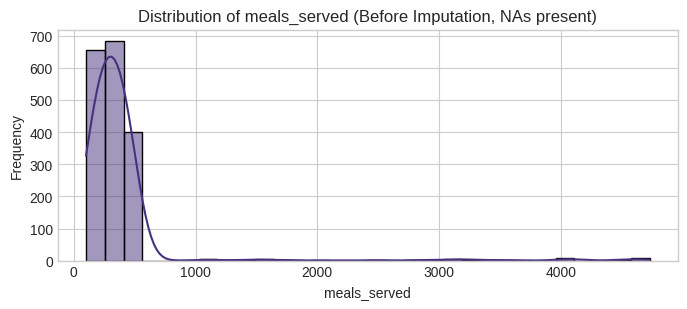

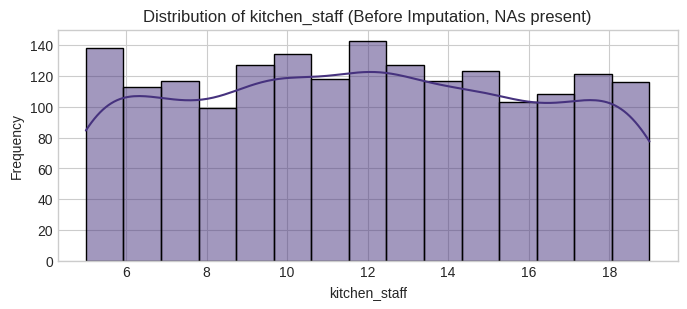

No missing values in 'temperature_c' to visualize pre-imputation distribution for NAs.


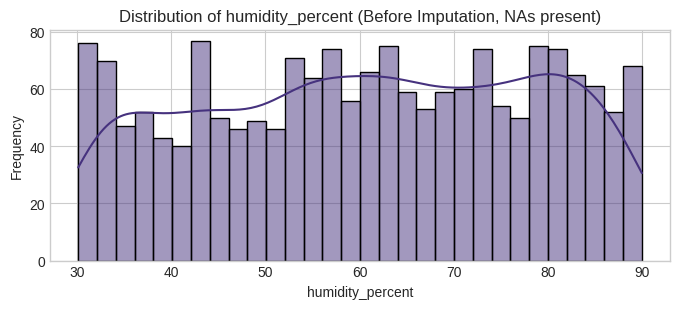

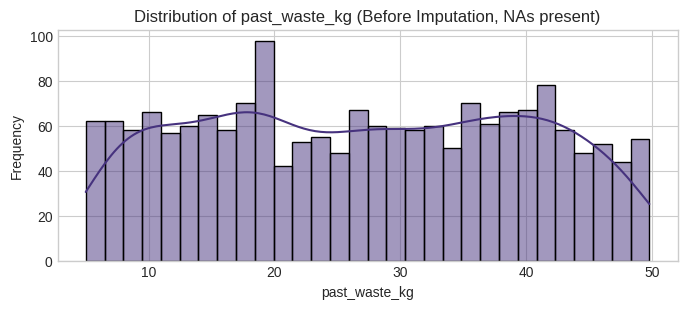

No missing values in 'day_of_week' to visualize pre-imputation distribution for NAs.
Imputed missing values in 'meals_served' using median (value: 306.00). Original skewness: 6.64
Imputed missing values in 'kitchen_staff' using mean (value: 11.90). Original skewness: 0.02
Imputed missing values in 'humidity_percent' using mean (value: 60.79). Original skewness: -0.09
Imputed missing values in 'past_waste_kg' using mean (value: 27.00). Original skewness: 0.02
Imputed missing values in 'staff_experience' using mode ('Intermediate').
Imputed missing values in 'waste_category' using mode ('Meat').
Re-mapped 'day_name' column after 'day_of_week' imputation.

--- Missing Value Imputation Complete ---
All missing values appear to be handled successfully!


<ipython-input-44-d7674e51fa03>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(impute_value, inplace=True)
<ipython-input-44-d7674e51fa03>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [44]:
# Checking for missing values, visualizing and imputation
print("--- Starting Missing Value Treatment ---")
# --- Missing Value Treatment ---
if not df.empty:
    # 1. Visualize distributions of numeric columns with missing values before imputation (PDF Task 2.2)
    print("\nVisualizing distributions of numeric features with missing values (before imputation):")
    numeric_cols_for_na_viz = ['meals_served', 'kitchen_staff', 'temperature_c', 'humidity_percent', 'past_waste_kg', 'day_of_week']
    for col in numeric_cols_for_na_viz:
        if col in df.columns and df[col].isnull().sum() > 0:
            plt.figure(figsize=(8, 3))
            sns.histplot(df[col].dropna(), kde=True, bins=min(30, df[col].dropna().nunique()))
            plt.title(f'Distribution of {col} (Before Imputation, NAs present)')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()
        elif col in df.columns:
            print(f"No missing values in '{col}' to visualize pre-imputation distribution for NAs.")


    # 2. Impute Missing Values (PDF Task 1.1, 1.3)
    # Numeric columns: Impute with mean or median based on skewness
    numeric_cols_to_impute = ['meals_served', 'kitchen_staff', 'temperature_c', 'humidity_percent', 'past_waste_kg', 'day_of_week']
    for col in numeric_cols_to_impute:
        if col in df.columns and df[col].isnull().any():
            skewness = df[col].dropna().skew()
            if abs(skewness) > 1:  # Threshold for using median for skewed data
                impute_value = df[col].median()
                imputation_method = 'median'
            else: # Use mean for more symmetrical data
                impute_value = df[col].mean()
                imputation_method = 'mean'
            df[col].fillna(impute_value, inplace=True)
            print(f"Imputed missing values in '{col}' using {imputation_method} (value: {impute_value:.2f}). Original skewness: {skewness:.2f}")

    # Categorical columns: Impute with mode (most frequent category)
    categorical_cols_to_impute = ['staff_experience', 'waste_category', 'day_name']
    for col in categorical_cols_to_impute:
        if col in df.columns and (df[col].isnull().sum() > 0 or df[col].isna().sum() > 0) : # Check for pd.NA or np.nan
            mode_val_series = df[col].mode()
            if not mode_val_series.empty:
                impute_cat_value = mode_val_series[0]
                df[col].fillna(impute_cat_value, inplace=True)
                print(f"Imputed missing values in '{col}' using mode ('{impute_cat_value}').")
            else: # Fallback if all values were NaN initially
                df[col].fillna('Unknown', inplace=True)
                print(f"Imputed missing values in '{col}' with 'Unknown' (mode was empty).")

    # If 'day_of_week' was imputed, 'day_name' needs to be re-mapped for those imputed rows
    if 'day_of_week' in numeric_cols_to_impute and 'day_name' in df.columns : # Check if day_of_week was in the imputation list
        # Re-create 'day_name' based on potentially imputed 'day_of_week'
        df['day_name'] = df['day_of_week'].astype(int).map(day_map_assignment) # Ensure day_of_week is int for mapping
        print("Re-mapped 'day_name' column after 'day_of_week' imputation.")


    print("\n--- Missing Value Imputation Complete ---")
    final_missing_check = df.isnull().sum()
    if final_missing_check.sum() == 0:
        print("All missing values appear to be handled successfully!")
    else:
        print("Warning: Some missing values may still remain. Review columns:")
        print(final_missing_check[final_missing_check > 0])
else:
    print("DataFrame 'df' is empty. Cannot perform imputation.")

**Handle duplicate rows**

In [45]:
# Checking the duplicate rows
print("\n--- Checking for and Removing Duplicate Rows ---")
if not df.empty:
    num_duplicates_before = df.duplicated().sum()
    print(f"Number of duplicate rows found before removal: {num_duplicates_before}")
    if num_duplicates_before > 0:
        df.drop_duplicates(inplace=True, keep='first') # Keep the first occurrence
        print(f"Dropped duplicate rows. New shape of DataFrame: {df.shape}")
        print(f"Number of duplicate rows remaining after removal: {df.duplicated().sum()}")
    else:
        print("No duplicate rows found to remove.")
else:
    print("DataFrame 'df' is empty.")


--- Checking for and Removing Duplicate Rows ---
Number of duplicate rows found before removal: 0
No duplicate rows found to remove.


**Correct Data Types and Standardize Categoricals**

In [46]:
# Fixing the data types and standardizing categoricals
print("\n--- Ensuring Correct Final Data Types ---")
if not df.empty:
    # Convert count-based columns to integer after imputation
    for col in ['meals_served', 'kitchen_staff', 'day_of_week']: # day_of_week should be int
        if col in df.columns and df[col].dtype != 'int64':
            try:
                df[col] = df[col].astype(int)
                print(f"'{col}' converted to int64.")
            except ValueError as e:
                print(f"Could not convert '{col}' to int: {e}. Check for non-integer coercible values if imputation was partial.")


    # Convert binary 'special_event' and other categoricals to category type for efficient storage and analysis
    for col in ['special_event', 'staff_experience', 'waste_category', 'day_name', 'month_name', 'year']:
        if col in df.columns:
            if col == 'day_name': # Ensure ordered for meaningful plots/sorts
                day_order_final = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
                df[col] = pd.Categorical(df[col], categories=day_order_final, ordered=True)
            else:
                df[col] = df[col].astype('category')
            print(f"'{col}' converted to category type.")

    print("\n--- Final Data Types and Info ---")
    df.info()
    print("\nFinal check for any remaining NaNs overall:", df.isnull().sum().sum())
else:
    print("DataFrame 'df' is empty.")


--- Ensuring Correct Final Data Types ---
'meals_served' converted to int64.
'kitchen_staff' converted to int64.
'day_of_week' converted to int64.
'special_event' converted to category type.
'staff_experience' converted to category type.
'waste_category' converted to category type.
'day_name' converted to category type.
'month_name' converted to category type.
'year' converted to category type.

--- Final Data Types and Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                1822 non-null   int64         
 1   date              1822 non-null   datetime64[ns]
 2   meals_served      1822 non-null   int64         
 3   kitchen_staff     1822 non-null   int64         
 4   temperature_c     1822 non-null   float64       
 5   humidity_percent  1822 non-null   float64       
 6   day_of_week       1822

**Statistical Summary**

In [47]:
# Extracting and printing the summary statistics
print("\n--- Summary Statistics for Numerical Columns ---")
if not df.empty:
    # Define columns for numeric summary, excluding 'id' and 'year' (which can be treated as categorical/time element)
    numeric_summary_cols_final = ['meals_served', 'kitchen_staff', 'temperature_c', 'humidity_percent', 'past_waste_kg']
    # Filter for columns actually present and numeric
    numeric_summary_cols_final = [col for col in numeric_summary_cols_final if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
    if numeric_summary_cols_final:
        print(df[numeric_summary_cols_final].describe())
    else:
        print("No suitable numeric columns found for summary statistics as defined.")

    print("\n--- Value Counts for Categorical Columns ---")
    # Define columns for categorical summary
    categorical_summary_cols_final = ['staff_experience', 'waste_category', 'day_name', 'special_event', 'month_name', 'year']
    # Filter for columns actually present
    categorical_summary_cols_final = [col for col in categorical_summary_cols_final if col in df.columns]
    if categorical_summary_cols_final:
        for col in categorical_summary_cols_final:
            print(f"\nValue counts for '{col}':")
            print(df[col].value_counts(dropna=False).sort_index()) # sort_index for consistent order
    else:
        print("No suitable categorical columns found for value counts as defined.")
else:
    print("DataFrame 'df' is empty.")


--- Summary Statistics for Numerical Columns ---
       meals_served  kitchen_staff  temperature_c  humidity_percent  \
count       1822.00        1822.00        1822.00           1822.00   
mean         372.33          11.90          22.19             60.79   
std          490.51           4.27           8.92             17.25   
min          100.00           5.00         -10.37             30.12   
25%          212.25           8.00          15.68             46.14   
50%          306.00          12.00          22.12             61.51   
75%          405.75          15.00          28.81             75.76   
max         4730.00          19.00          60.00             89.98   

       past_waste_kg  
count        1822.00  
mean           27.00  
std            12.74  
min             5.01  
25%            16.15  
50%            27.00  
75%            37.98  
max            49.80  

--- Value Counts for Categorical Columns ---

Value counts for 'staff_experience':
staff_experience
Be

**Visualization - Distributions**


--- Visualizing Distributions ---

Distributions of Numerical Features:


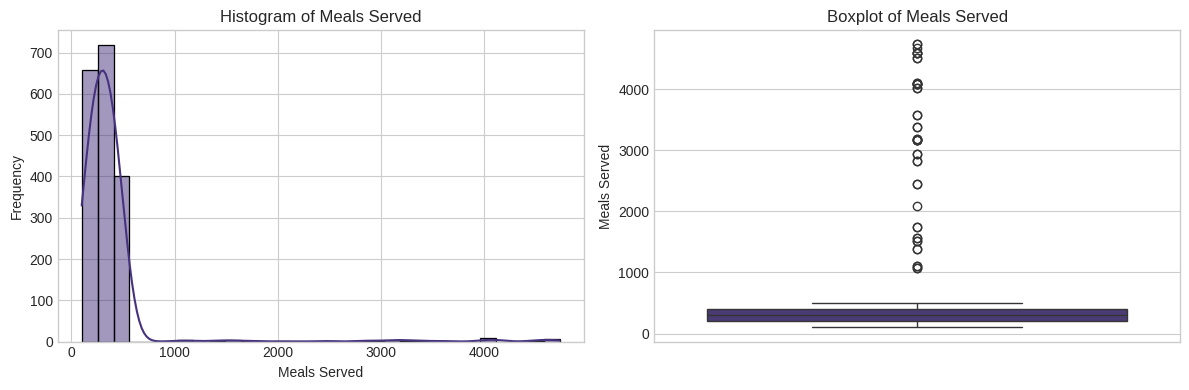

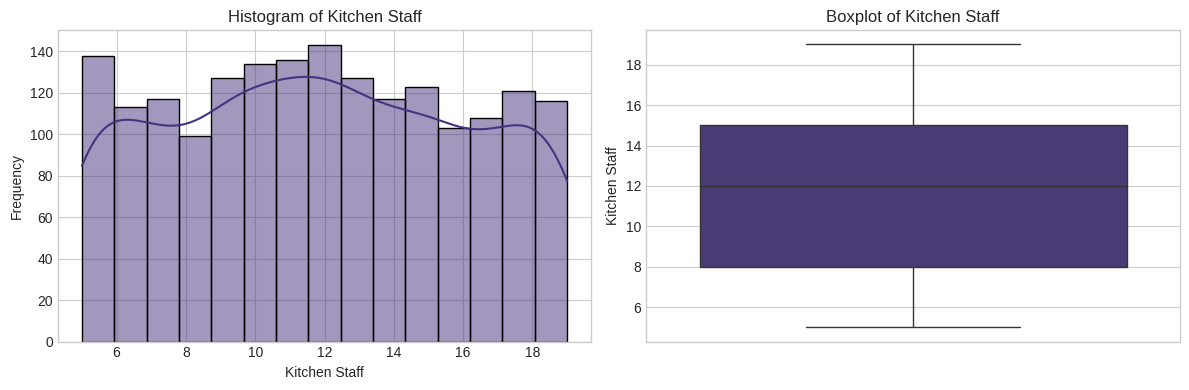

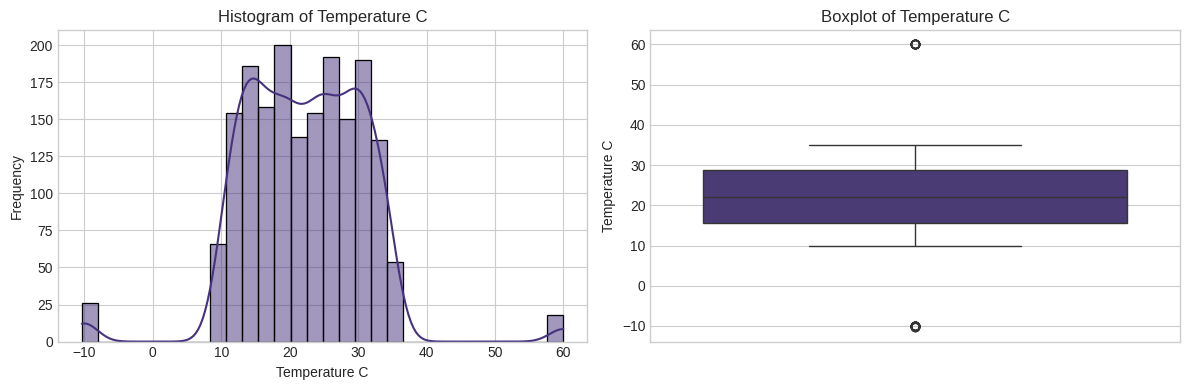

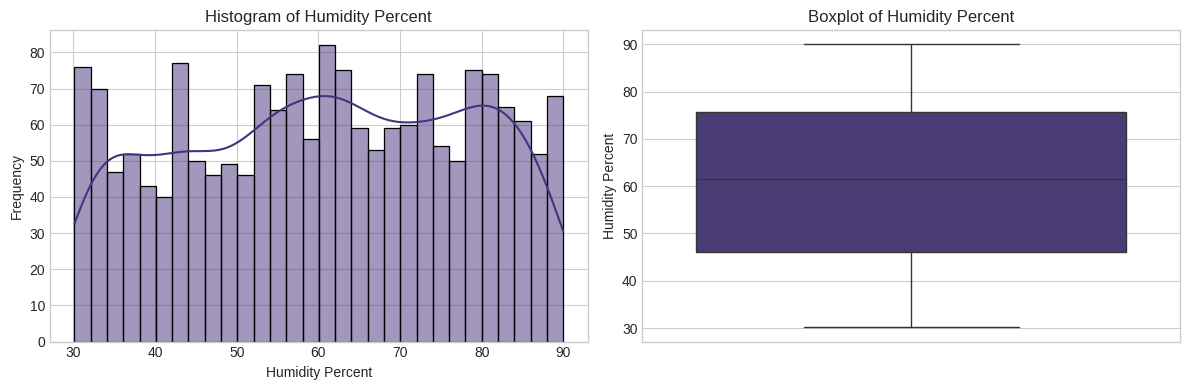

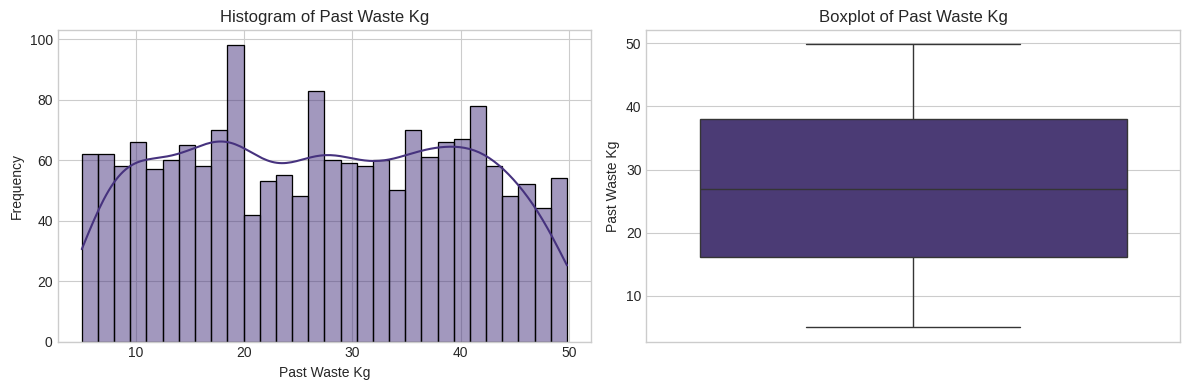


Distributions of Categorical Features:


<ipython-input-48-bd7d3b9c213f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette='viridis')


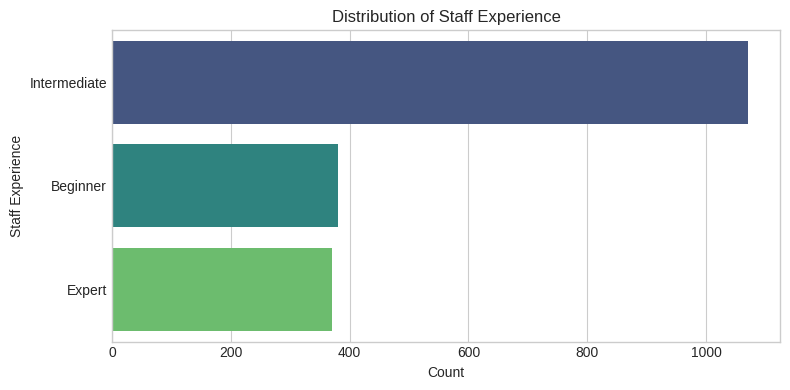

<ipython-input-48-bd7d3b9c213f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette='viridis')


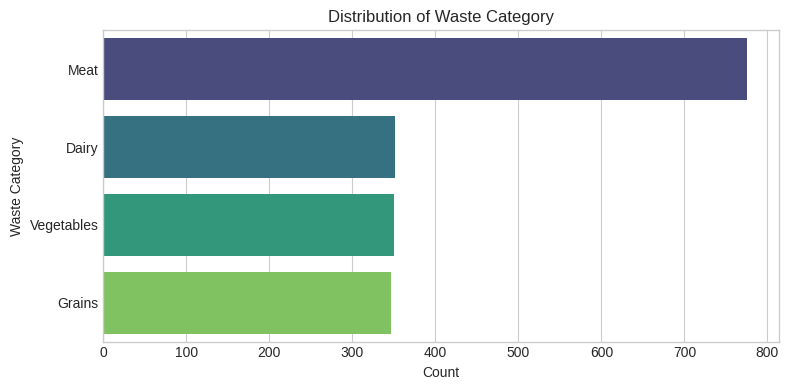

<ipython-input-48-bd7d3b9c213f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette='viridis')


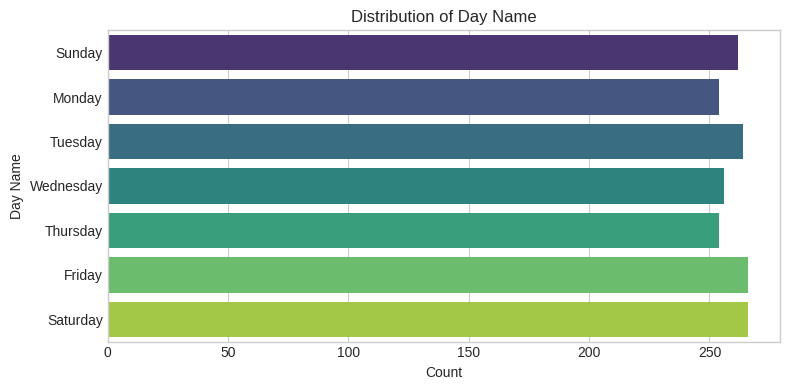

<ipython-input-48-bd7d3b9c213f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette='viridis')


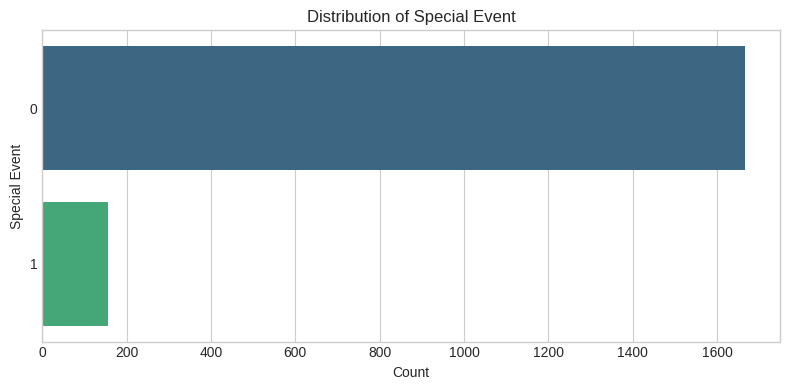

<ipython-input-48-bd7d3b9c213f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=order, palette='viridis')


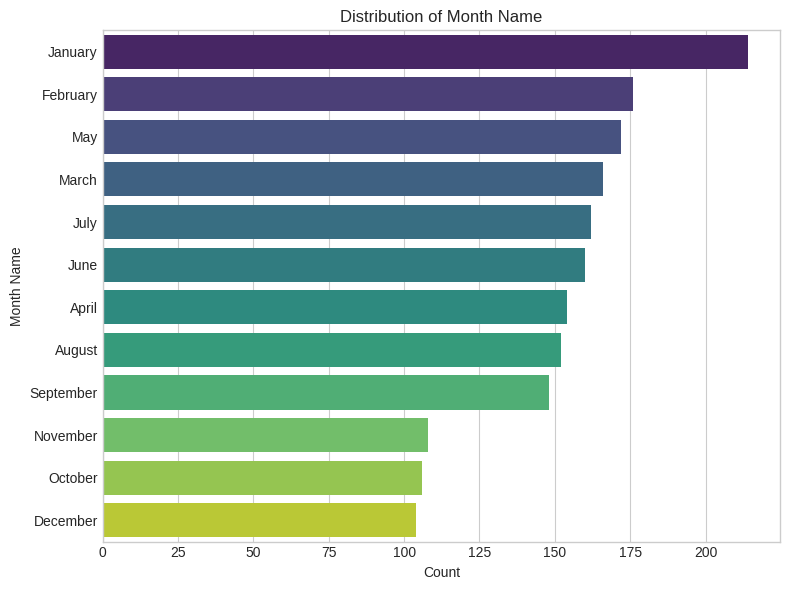

In [48]:
# Visualize data distributions
print("\n--- Visualizing Distributions ---")
if not df.empty:
    # Histograms and Boxplots for numerical features (PDF Task 2.2a, 2.2b)
    print("\nDistributions of Numerical Features:")
    numerical_features_to_viz = ['meals_served', 'kitchen_staff', 'temperature_c', 'humidity_percent', 'past_waste_kg']
    for col in numerical_features_to_viz:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            sns.histplot(df[col], kde=True, bins=min(30, df[col].nunique()))
            plt.title(f'Histogram of {col.replace("_", " ").title()}')
            plt.xlabel(col.replace("_", " ").title())
            plt.ylabel('Frequency')

            plt.subplot(1, 2, 2)
            sns.boxplot(y=df[col])
            plt.title(f'Boxplot of {col.replace("_", " ").title()}')
            plt.ylabel(col.replace("_", " ").title())
            plt.tight_layout()
            plt.show()
        else:
            print(f"Column '{col}' not found or not numeric, skipping visualization.")

    # Bar plots for categorical variables (PDF Task 2.2c, 5)
    print("\nDistributions of Categorical Features:")
    categorical_features_to_viz = ['staff_experience', 'waste_category', 'day_name', 'special_event', 'month_name']
    for col in categorical_features_to_viz:
        if col in df.columns and df[col].dtype.name == 'category':
            plt.figure(figsize=(8, max(4, df[col].nunique() * 0.5)))
            order = df[col].value_counts().index
            if df[col].cat.ordered: # Use category order if defined (e.g., for day_name)
                order = df[col].cat.categories
            sns.countplot(data=df, y=col, order=order, palette='viridis')
            plt.title(f'Distribution of {col.replace("_", " ").title()}')
            plt.xlabel('Count')
            plt.ylabel(col.replace("_", " ").title())
            plt.tight_layout()
            plt.show()
        else:
            print(f"Column '{col}' not found or not categorical, skipping bar plot.")
else:
    print("DataFrame 'df' is empty.")

**Outlier Detection and Analysis**

In [49]:
# --- Outlier Detection and Analysis ---
print("\n--- Identifying Potential Outliers using IQR Method (Supplements Boxplots) ---")
if not df.empty:
    # Columns to check for outliers (key numerical features)
    numeric_cols_for_outlier_check = ['meals_served', 'kitchen_staff', 'temperature_c', 'humidity_percent', 'past_waste_kg']

    for col in numeric_cols_for_outlier_check:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

            if not outliers.empty:
                print(f"\nPotential outliers detected in '{col}':")
                print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
                print(f"  Description of outliers in '{col}':\n{outliers[col].describe()}")
            else:
                print(f"\nNo significant outliers detected in '{col}' using the 1.5*IQR rule.")
else:
    print("DataFrame 'df' is empty. Cannot perform outlier detection.")


--- Identifying Potential Outliers using IQR Method (Supplements Boxplots) ---

Potential outliers detected in 'meals_served':
  Number of outliers: 46 (2.52%)
  Description of outliers in 'meals_served':
count     46.00
mean    3092.61
std     1215.19
min     1070.00
25%     1832.50
50%     3180.00
75%     4080.00
max     4730.00
Name: meals_served, dtype: float64

No significant outliers detected in 'kitchen_staff' using the 1.5*IQR rule.

Potential outliers detected in 'temperature_c':
  Number of outliers: 44 (2.41%)
  Description of outliers in 'temperature_c':
count    44.00
mean     18.62
std      34.83
min     -10.37
25%     -10.00
50%     -10.00
75%      60.00
max      60.00
Name: temperature_c, dtype: float64

No significant outliers detected in 'humidity_percent' using the 1.5*IQR rule.

No significant outliers detected in 'past_waste_kg' using the 1.5*IQR rule.


**Correlation Analysis**


--- Correlation Matrix for Numerical Variables ---


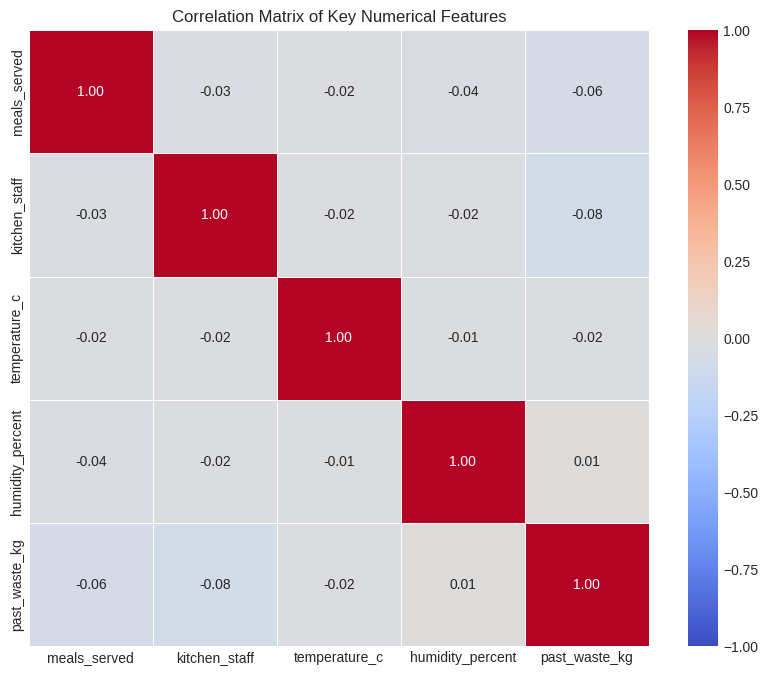


Correlations with 'past_waste_kg':
past_waste_kg       1.00
humidity_percent    0.01
temperature_c      -0.02
meals_served       -0.06
kitchen_staff      -0.08
Name: past_waste_kg, dtype: float64


In [50]:
# Correlation Analysis
print("\n--- Correlation Matrix for Numerical Variables ---")
if not df.empty:
    numeric_corr_cols = ['meals_served', 'kitchen_staff', 'temperature_c', 'humidity_percent', 'past_waste_kg']
    # Filter for columns that are present and numeric
    numeric_corr_cols_present = [col for col in numeric_corr_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

    if len(numeric_corr_cols_present) > 1:
        correlation_matrix = df[numeric_corr_cols_present].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=.5)
        plt.title('Correlation Matrix of Key Numerical Features')
        plt.show()

        if 'past_waste_kg' in correlation_matrix.columns:
            print("\nCorrelations with 'past_waste_kg':")
            print(correlation_matrix['past_waste_kg'].sort_values(ascending=False))
    else:
        print("Not enough numeric columns for a meaningful correlation matrix.")
else:
    print("DataFrame 'df' is empty.")

**Hypothesis Testing**

`NOTE: Pardon, my use of hypothesis testing here might be a bit off. I'm still working on understanding and leveraging it holistically.`


--- Hypothesis Testing ---

Hypothesis Test 1: Impact of Kitchen Staff Levels on Food Waste
Null hypothesis (H0): There is no relationship (no difference in means) between kitchen staff levels and food waste.
Alternative hypothesis (H1): Kitchen staff levels significantly affect food waste (means are different).

ANOVA results for kitchen staff levels vs. food waste:
  F-statistic: 4.050
  P-value: 0.0176
  Conclusion: Reject H0. There is a statistically significant difference in food waste across kitchen staff levels (p < 0.05).


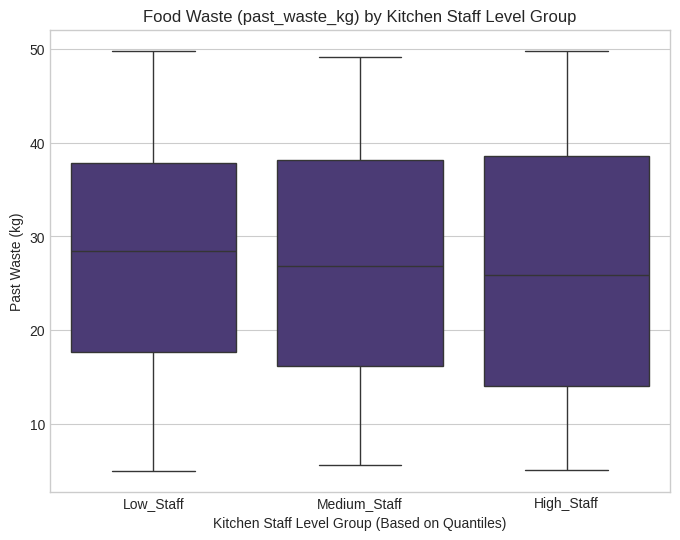


Hypothesis Test 2: Impact of Special Events on Food Waste
Null hypothesis (H0): There is no difference in food waste between special event days and non-special event days.
Alternative hypothesis (H1): Food waste is different (e.g., higher or lower) on special event days.

Levene's test for equal variances (event vs. non-event): p-value = 0.5019
Independent Samples T-test (equal_var=True):
  T-statistic: 0.284
  P-value: 0.7763
  Conclusion: Fail to reject H0. No statistically significant difference in food waste (p >= 0.05).
  Mean waste on event days: 27.27 kg
  Mean waste on non-event days: 26.97 kg


<ipython-input-51-6179d3a97958>:80: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df['special_event']):


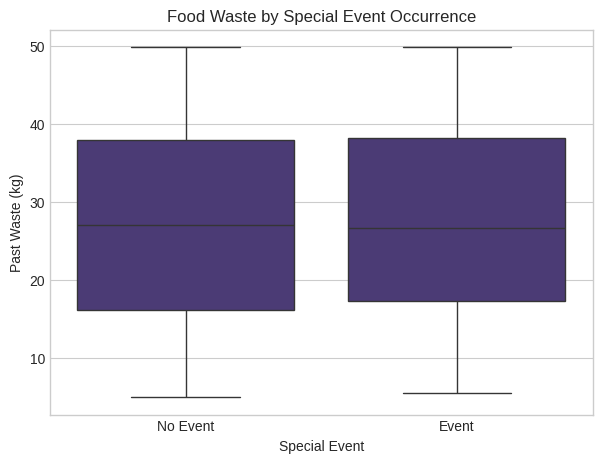

In [51]:
# Hypothesis testing
print("\n--- Hypothesis Testing ---")
if not df.empty:
    # Impact of Kitchen Staff on Food Waste (ANOVA)
    print("\nHypothesis Test 1: Impact of Kitchen Staff Levels on Food Waste")
    print("Null hypothesis (H0): There is no relationship (no difference in means) between kitchen staff levels and food waste.")
    print("Alternative hypothesis (H1): Kitchen staff levels significantly affect food waste (means are different).")

    if 'kitchen_staff' in df.columns and 'past_waste_kg' in df.columns:
        try:
            if df['kitchen_staff'].nunique() >= 3:
                # Create staff groups using quantiles for roughly equal group sizes
                df['staff_level_group'] = pd.qcut(df['kitchen_staff'], q=3, labels=['Low_Staff', 'Medium_Staff', 'High_Staff'], duplicates='drop')

                group_low_staff = df[df['staff_level_group'] == 'Low_Staff']['past_waste_kg'].dropna()
                group_medium_staff = df[df['staff_level_group'] == 'Medium_Staff']['past_waste_kg'].dropna()
                group_high_staff = df[df['staff_level_group'] == 'High_Staff']['past_waste_kg'].dropna()

                # Check for sufficient sample size in each group for ANOVA
                if all(len(group) >= 2 for group in [group_low_staff, group_medium_staff, group_high_staff]):
                    f_statistic_staff, p_value_anova_staff = stats.f_oneway(group_low_staff, group_medium_staff, group_high_staff)
                    print(f"\nANOVA results for kitchen staff levels vs. food waste:")
                    print(f"  F-statistic: {f_statistic_staff:.3f}")
                    print(f"  P-value: {p_value_anova_staff:.4f}")
                    alpha = 0.05
                    if p_value_anova_staff < alpha:
                        print(f"  Conclusion: Reject H0. There is a statistically significant difference in food waste across kitchen staff levels (p < {alpha}).")
                    else:
                        print(f"  Conclusion: Fail to reject H0. There is no statistically significant difference in food waste across kitchen staff levels (p >= {alpha}).")

                    plt.figure(figsize=(8, 6))
                    sns.boxplot(x='staff_level_group', y='past_waste_kg', data=df, order=['Low_Staff', 'Medium_Staff', 'High_Staff'])
                    plt.title('Food Waste (past_waste_kg) by Kitchen Staff Level Group')
                    plt.xlabel('Kitchen Staff Level Group (Based on Quantiles)')
                    plt.ylabel('Past Waste (kg)')
                    plt.show()
                else:
                    print("Not enough data in one or more staff groups for ANOVA after grouping by quantiles.")
            else:
                print("Not enough unique 'kitchen_staff' values to form 3 distinct groups for ANOVA using quantiles.")
        except ValueError as e_anova_staff:
            print(f"Could not perform ANOVA for kitchen staff groups: {e_anova_staff}")
    else:
        print("Skipping kitchen staff vs. waste ANOVA: required columns ('kitchen_staff', 'past_waste_kg') not found.")

    # Special Events and Food Waste (t-test)
    print("\nHypothesis Test 2: Impact of Special Events on Food Waste")
    print("Null hypothesis (H0): There is no difference in food waste between special event days and non-special event days.")
    print("Alternative hypothesis (H1): Food waste is different (e.g., higher or lower) on special event days.")

    if 'special_event' in df.columns and 'past_waste_kg' in df.columns and df['special_event'].nunique() == 2:
        # Assuming 'special_event' is 0 (no event) and 1 (event) after cleaning
        waste_event = df[df['special_event'] == 1]['past_waste_kg'].dropna()
        waste_nonevent = df[df['special_event'] == 0]['past_waste_kg'].dropna()

        if len(waste_event) >= 2 and len(waste_nonevent) >= 2: # Minimum samples for t-test
            # Check for homogeneity of variances using Levene's test
            levene_stat, levene_p = stats.levene(waste_event, waste_nonevent)
            print(f"\nLevene's test for equal variances (event vs. non-event): p-value = {levene_p:.4f}")
            equal_var_assumption = levene_p > 0.05 # If p > 0.05, assume equal variances

            t_statistic_event, p_value_ttest_event = stats.ttest_ind(waste_event, waste_nonevent, equal_var=equal_var_assumption)
            print(f"Independent Samples T-test (equal_var={equal_var_assumption}):")
            print(f"  T-statistic: {t_statistic_event:.3f}")
            print(f"  P-value: {p_value_ttest_event:.4f}")
            alpha = 0.05
            if p_value_ttest_event < alpha:
                print(f"  Conclusion: Reject H0. There is a statistically significant difference in food waste between event and non-event days (p < {alpha}).")
                print(f"  Mean waste on event days: {waste_event.mean():.2f} kg")
                print(f"  Mean waste on non-event days: {waste_nonevent.mean():.2f} kg")
            else:
                print(f"  Conclusion: Fail to reject H0. No statistically significant difference in food waste (p >= {alpha}).")
                print(f"  Mean waste on event days: {waste_event.mean():.2f} kg")
                print(f"  Mean waste on non-event days: {waste_nonevent.mean():.2f} kg")

            plt.figure(figsize=(7, 5))
            sns.boxplot(x='special_event', y='past_waste_kg', data=df)
            plt.title('Food Waste by Special Event Occurrence')
            plt.xlabel('Special Event')
            if pd.api.types.is_categorical_dtype(df['special_event']):
                 plt.xticks(ticks=df['special_event'].cat.categories, labels=['No Event', 'Event'])
            else:
                 plt.xticks(ticks=[0, 1], labels=['No Event', 'Event'])
            plt.ylabel('Past Waste (kg)')
            plt.show()
        else:
            print("Not enough data for T-test on special events (one or both groups have < 2 samples).")
    else:
        print("Skipping special event vs. waste t-test: 'special_event' is not binary or required columns missing.")
else:
    print("DataFrame 'df' is empty.")

**Insights and Recommendations**

### Key insights driven through EDA:

1.  **Meals Served vs. Waste:**
    * There is a very weak negative correlation (**-0.06**) between `meals_served` and `past_waste_kg`. This suggests that the number of meals served has minimal linear impact on the quantity of past waste recorded, possibly indicating effective forecasting or other factors being more influential.

2.  **Special Events & Waste:**
    * The average food waste on days with special events was **27.27 kg**, while on non-event days it was **26.97 kg**.
    * An independent samples t-test (after Levene's test indicated equal variances, p=0.5019) yielded a p-value of **0.7763**. This indicates there is **no statistically significant difference** in food waste between special event days and non-special event days.

3.  **Staff Experience & Waste:**
    * Analysis of mean waste by staff experience level shows:
        * Beginner staff: **28.33 kg**
        * Intermediate staff: **27.39 kg**
        * Expert staff: **26.50 kg**
    * This indicates a trend where waste decreases with increasing staff experience.

4.  **Dominant Waste Category:**
    * **Meat** is the most significant contributor to food waste, accounting for approximately **42.54%** (775 out of 1822 total imputed entries) of the waste instances by category. This highlights meat products as a key area for waste reduction efforts.

5.  **Weekly Waste Patterns (0=Sunday):**
    * Food waste exhibits weekly patterns. Based on the dataset's `day_of_week` encoding (0=Sunday), the highest average waste occurs on:
        * **Wednesday**: **28.94 kg**
        * **Saturday**: **28.17 kg**
6.  **Kitchen Staff Numbers & Waste:**
    * An ANOVA test comparing food waste across different kitchen staff level groups (Low, Medium, High based on quantiles) yielded an F-statistic of **4.050** and a p-value of **0.0176**.
    * This indicates that there is a **statistically significant difference** in food waste across different kitchen staff levels.

### Recommendations:

1.  **Maintain Forecasting & Explore Other Factors:**
    * Given the weak correlation between meals served and waste, continue current forecasting practices. Investigate other operational factors that might have a stronger influence on waste generation.

2.  **Special Event Planning:**
    * Since special events do not show a statistically significant impact on overall waste, current planning protocols for these days might be largely effective. However, it's still prudent to monitor waste on an event-by-event basis due to potential variability.

3.  **Staff Development & Knowledge Sharing:**
    * Address the trend of higher waste with less experienced staff by implementing targeted training for Beginner and Intermediate staff. Focus on waste reduction techniques and potentially pair them with Expert staff for mentorship.

4.  **Prioritize Meat Waste Reduction:**
    * With Meat being the dominant waste category (42.54%), conduct a thorough review of meat procurement (e.g., order quantities vs. actual use), storage (e.g., FIFO, temperature control), preparation (e.g., trim waste, overproduction), and portioning strategies to identify specific areas for significant waste reduction.

5.  **Optimize for Peak Waste Days:**
    * For the identified peak waste days (Wednesday and Saturday, based on 0=Sunday mapping), analyze menu demand, preparation volumes, and staffing on these days. Implement strategies like just-in-time preparation for certain items or menu adjustments to reduce overproduction.

6.  **Investigate Kitchen Staff Impact:**
    * Since kitchen staff levels show a significant relationship with waste, delve deeper into *how* different staffing levels or team compositions affect waste. For example, analyze if very low or very high staff numbers correlate with increased waste and identify an optimal range or best practices within different staff group sizes.